In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC

data = pd.read_csv("healthcare-dataset-stroke-data.csv")

balanced_data = data.dropna()
balanced_data = balanced_data.drop(columns= "id")
balanced_data = balanced_data[balanced_data.age > 20]
balanced_data = balanced_data.drop(balanced_data.index[balanced_data["gender"] == "Other"])
balanced_data = balanced_data.drop(balanced_data.index[balanced_data["work_type"] == "Never_worked"])

features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', "bmi", "smoking_status"]
cat_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
num_columns = ['age', 'avg_glucose_level', 'bmi']

bal_data_train, bal_data_test = train_test_split(balanced_data, train_size = 0.8, random_state=1, stratify= balanced_data["stroke"])
bal_data_train, bal_data_val = train_test_split(bal_data_train, train_size = 0.8, random_state=1)

X_train = bal_data_train.drop('stroke', axis = 1)
y_train = bal_data_train['stroke']

X_val = bal_data_val.drop('stroke', axis = 1)
y_val = bal_data_val['stroke']

X_test = bal_data_test.drop('stroke', axis = 1)
y_test = bal_data_test['stroke']

In [16]:
X_test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
333,Female,52.0,0,0,Yes,Private,Urban,82.24,54.7,formerly smoked
2362,Female,80.0,0,1,Yes,Self-employed,Rural,98.39,22.2,smokes
450,Male,72.0,0,1,Yes,Self-employed,Rural,97.53,29.4,smokes
5014,Male,29.0,0,0,No,Private,Urban,82.93,29.4,formerly smoked
3691,Female,75.0,0,0,Yes,Self-employed,Urban,60.60,40.4,smokes
...,...,...,...,...,...,...,...,...,...,...
4529,Male,82.0,0,1,Yes,Private,Urban,57.56,27.5,never smoked
1236,Male,67.0,0,0,Yes,Govt_job,Rural,93.71,31.2,formerly smoked
3512,Female,38.0,0,0,Yes,Private,Rural,66.16,42.7,Unknown
2309,Female,50.0,0,0,Yes,Govt_job,Urban,89.95,48.9,formerly smoked


In [17]:
smotenc = SMOTENC(cat_columns, random_state= 1)

X_train, y_train = smotenc.fit_resample(X_train, y_train)

In [18]:
preprocessing = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(sparse_output=False), cat_columns),
    ('scaler', StandardScaler(), num_columns)
])

In [19]:
X_train2 = preprocessing.fit_transform(X_train)
X_val2 = preprocessing.transform(X_val)
X_test2 = preprocessing.transform(X_test)

Initial model starts at 0.07 recall

In [20]:
import tensorflow as tf

tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=20))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(512, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.00001)))
model.add(tf.keras.layers.Dropout(0.8))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.00001)))
model.add(tf.keras.layers.Dropout(0.8))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.00001)))
model.add(tf.keras.layers.Dropout(0.8))


model.add(tf.keras.layers.Dense(1, "sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['Recall'])

In [21]:
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 512)               10752     
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [22]:
model_history = model.fit(X_train2, y_train, validation_data=(X_val2, y_val), epochs=100, callbacks= [callback])

Epoch 1/100
149/149 [==============================] - 3s 11ms/step - loss: 1.0233 - recall: 0.5308 - val_loss: 0.6804 - val_recall: 0.9211
Epoch 2/100
149/149 [==============================] - 1s 9ms/step - loss: 0.7832 - recall: 0.5991 - val_loss: 0.6030 - val_recall: 0.8684
Epoch 3/100
149/149 [==============================] - 1s 9ms/step - loss: 0.6698 - recall: 0.6535 - val_loss: 0.5470 - val_recall: 0.8421
Epoch 4/100
149/149 [==============================] - 2s 13ms/step - loss: 0.6053 - recall: 0.7137 - val_loss: 0.5466 - val_recall: 0.8684
Epoch 5/100
149/149 [==============================] - 2s 12ms/step - loss: 0.5702 - recall: 0.7719 - val_loss: 0.5595 - val_recall: 0.8684
Epoch 6/100
149/149 [==============================] - 1s 9ms/step - loss: 0.5558 - recall: 0.7997 - val_loss: 0.5312 - val_recall: 0.8421
Epoch 7/100
149/149 [==============================] - 1s 9ms/step - loss: 0.5401 - recall: 0.8103 - val_loss: 0.5469 - val_recall: 0.8421
Epoch 8/100
149/149 [===

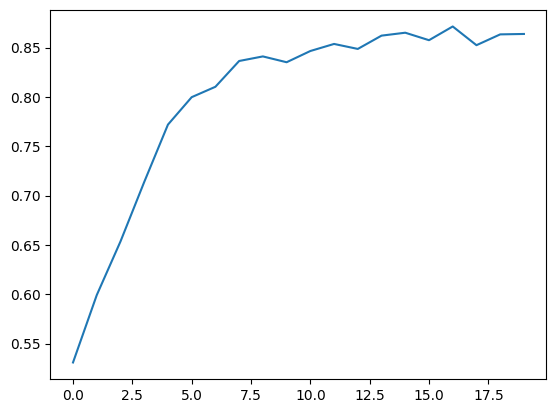

In [23]:
plt.plot(model_history.history['recall'])

In [24]:
model.evaluate(X_test2, y_test)

25/25 [==============================] - 0s 4ms/step - loss: 0.5976 - recall: 0.4048


[0.597622275352478, 0.4047619104385376]

In [25]:
model.save('NN.h5')